In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
import numpy as np
import seaborn as sns
sns.set_theme(context="poster", style="darkgrid", palette="colorblind")

torch.manual_seed(1)
np.random.seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the data

In [ ]:
mat = scipy.io.loadmat("Xtrain.mat")["Xtrain"]

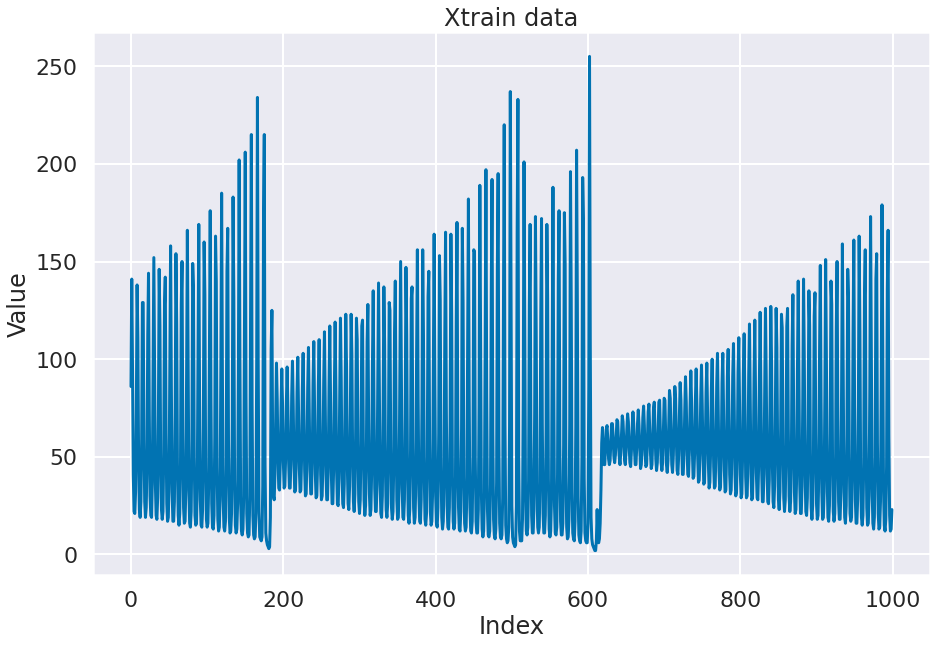

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(mat)
plt.title("Xtrain data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [ ]:
print("Average:", np.average(mat))

Average: 59.894


In [ ]:
def scale_the_data(mat):
  """
  Normalize the data
  """
  min_value= np.min(mat)
  max_value= np.max(mat)
  normalized_data = (mat.copy() - min_value)/(max_value-min_value)
  normalized_data - 0.5
  return min_value, max_value, normalized_data

def scale_back(data, min_, max_):
    return data * (max_ - min_) + min_

In [ ]:
def make_dataset(data, window_size, val_size = 0, shuffle = False):
    """
    Organize the data in such a way we can use it for training

    Given a series [a0, a1, a2, ..., an]
    This should return a matrix X and vector Y
    X: 
    [
        a0, a1, ..., ai         window_size elements
        a1, a2, ...,ai+1
        ...
    ]

    Y: [ai+1, ai+2, ...]
    """
    # -------------------------------------|---------------
    if val_size == 0:
        train = data
        X_val = torch.zeros((0, 1, 1))
        Y_val = torch.zeros((0, 1, 1))
    else:
        val = data[-(window_size + val_size):] 
        train = data[:-(window_size + val_size)]
        
        X_val= np.lib.stride_tricks.sliding_window_view(val[:-1].copy(), window_size, axis=0)        
        Y_val= val[window_size:].reshape(-1, 1, 1).copy()
        X_val = torch.tensor(X_val, dtype=torch.float32)
        Y_val = torch.tensor(Y_val, dtype=torch.float32)
        
    X_train= np.lib.stride_tricks.sliding_window_view(train[:-1].copy(), window_size, axis=0)
    Y_train= train[window_size:].reshape(-1, 1, 1).copy()
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    
    if shuffle:        
        train_perm = torch.randperm(X_train.shape[0])
        X_train = X_train[train_perm]
        Y_train = Y_train[train_perm]

    return X_train, Y_train, X_val, Y_val

# Define the models

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers=1, dropout=0.5):
          super().__init__()

          # The LSTM takes sequences as inputs, and outputs the predicted value
          # with dimensionality hidden_size.
          self.lstm = nn.LSTM(input_size, hidden_size, layers)

          #connection to the dropout layer
          self.dropout = nn.Dropout(dropout)

          # The layer that maps from hidden state space to output space
          self.hidden2output = nn.Linear(hidden_size, output_size) 


    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        dropout = self.dropout(lstm_out)
        output = self.hidden2output(dropout) 
        return F.relu(output)      
        
    def predict(self, x, n=200):
        output = torch.cat((x, torch.zeros(n, device = x.device)))
        for i in range(n):
            sequence = output[i: i + x.shape[0]]
            prediction = self(sequence)
            output[i + x.shape[0]] = prediction
        return output[-n:]
  

class ReLUModel(nn.Module): # We don't have much data, so we can with try a smaller model
    def __init__(self, input_size, hidden_size, output_size, dropout=0.5):
        super().__init__()
        # h1 h2
        # input - relu - lin - drop - - relu - lin - drop - output
        
        self.relu = [nn.Linear(input_size, hidden_size[0])]
        for i in range(len(hidden_size) -1):
            self.relu.append(nn.ReLU())
            self.relu.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            self.relu.append(nn.Dropout(dropout))
        self.relu.append(nn.Linear(hidden_size[-1], output_size))
        self.relu = nn.Sequential(*self.relu)

    def forward(self, x):
        # for i in self.relu[:-1]:
        #     x = F.relu(i(x))
        #     x = self.dropout(x)
        # x = F.relu(self.relu[-1](x)) 
        return self.relu(x)

    def predict(self, x, n=200):
        output = torch.cat((x, torch.zeros(n, device = x.device)))
        for i in range(n):
            sequence = output[i: i + x.shape[0]]
            prediction = self(sequence)
            output[i + x.shape[0]] = prediction
        return output[-n:]        

# Train the models

In [ ]:
def train(x_train, y_train, x_val, y_val, model, optimizer, criterion, epochs):
    model.train()
    losses = [0 for e in range(epochs)]
    val_losses = [0 for e in range(epochs)]
    
    for e in range(epochs):  
        y_pred = model(x_train)    
        loss = criterion(y_pred, y_train)        
        losses[e] = loss.item()        

        if e % 100 == 99:
            print(f"Epoch {e+1}:", loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if x_val.shape[0] != 0:
            y_pred_val = model(x_val)
            val_loss = criterion(y_pred_val, y_val)
            val_losses[e] = val_loss.item()
    return losses, val_losses

def test(x, y, model, criterions, min_= None, max_= None):
    model.eval()
    y_pred = model(x)
    if min_ is not None and max_ is not None:
        y_pred = scale_back(y_pred, min_, max_)
        y = scale_back(y, min_, max_)

    if isinstance(criterions, list) or isinstance(criterions, tuple):
        loss = [i(y_pred, y).item() for i in criterions]
    else:
        loss =criterions(y_pred, y).item()
    return loss, y, y_pred

def load(path):
    model = torch.load(path)
    model.eval()
    return model

def save(model, path):
    torch.save(model, path)

def plot_loss(title, loss, val_loss):
    plt.figure(figsize=(10, 8))
    plt.plot(loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def plot_predictions(title, y, y_pred):
    y = y.clone().cpu()
    y_pred = y_pred.clone().cpu()
    y = y.reshape(-1).detach().numpy()
    y_pred = y_pred.reshape(-1).detach().numpy()    

    plt.figure(figsize=(10, 8))
    plt.plot(y, label="y")
    plt.plot(y_pred, label="prediction")
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


In [ ]:
def make_RMSE():
    mse = nn.MSELoss()
    def RMSE(y_pred, y):
        return torch.sqrt(mse(y_pred, y))
    return RMSE


Epoch 100: 0.02429855987429619
Epoch 200: 0.01781543157994747
Epoch 300: 0.013668932020664215
Epoch 400: 0.01170972641557455
Epoch 500: 0.01176027674227953
Epoch 600: 0.010563571006059647
Epoch 700: 0.00885371770709753
Epoch 800: 0.009655360132455826
Epoch 900: 0.009034639224410057
Epoch 1000: 0.00950116477906704


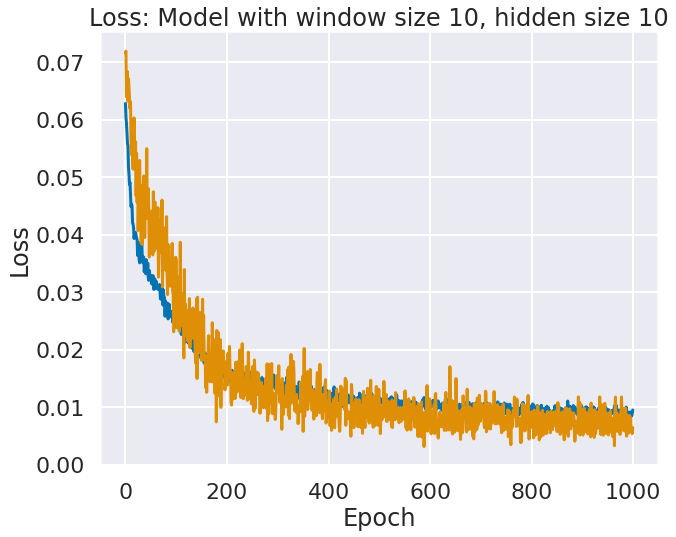

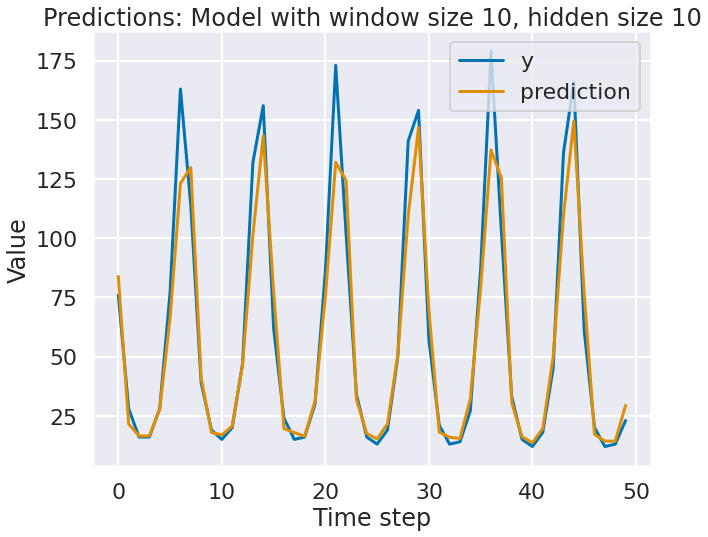

Loss (MSE): 212.85418701171875
------------------------------------------------------
Epoch 100: 0.03048700839281082
Epoch 200: 0.021023685112595558
Epoch 300: 0.015726318582892418
Epoch 400: 0.01235551293939352
Epoch 500: 0.01095546130090952
Epoch 600: 0.010512220673263073
Epoch 700: 0.00960428174585104
Epoch 800: 0.009695029817521572
Epoch 900: 0.00874505378305912
Epoch 1000: 0.00916061270982027


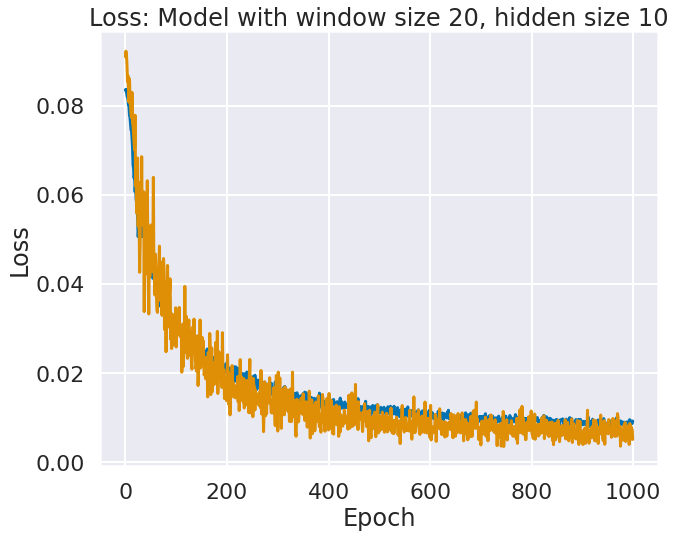

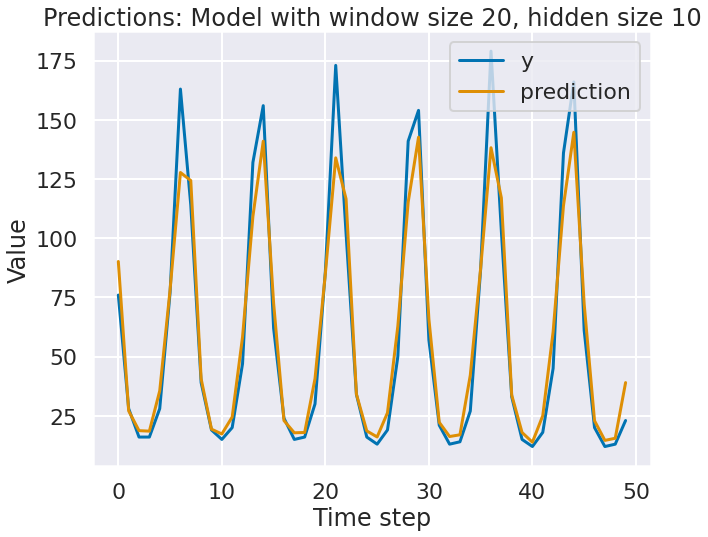

Loss (MSE): 187.34432983398438
------------------------------------------------------
Epoch 100: 0.021390676498413086
Epoch 200: 0.014492031186819077
Epoch 300: 0.011720587499439716
Epoch 400: 0.010025211609899998
Epoch 500: 0.009547365829348564
Epoch 600: 0.00948714092373848
Epoch 700: 0.007810331881046295
Epoch 800: 0.008262604475021362
Epoch 900: 0.007719628978520632
Epoch 1000: 0.007218072656542063


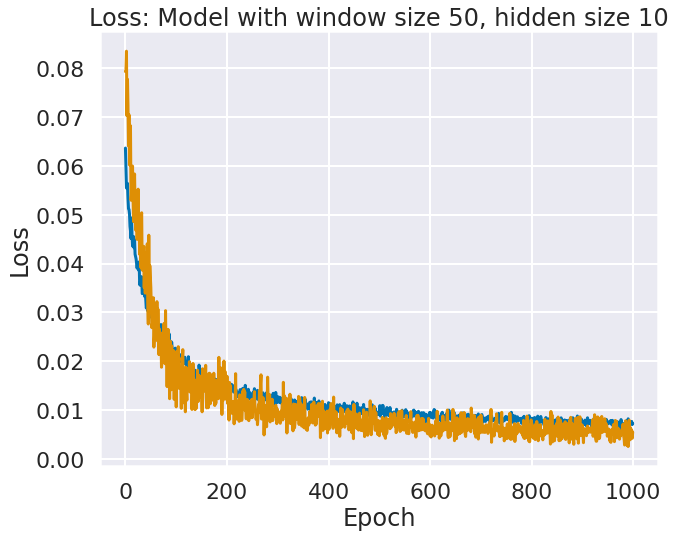

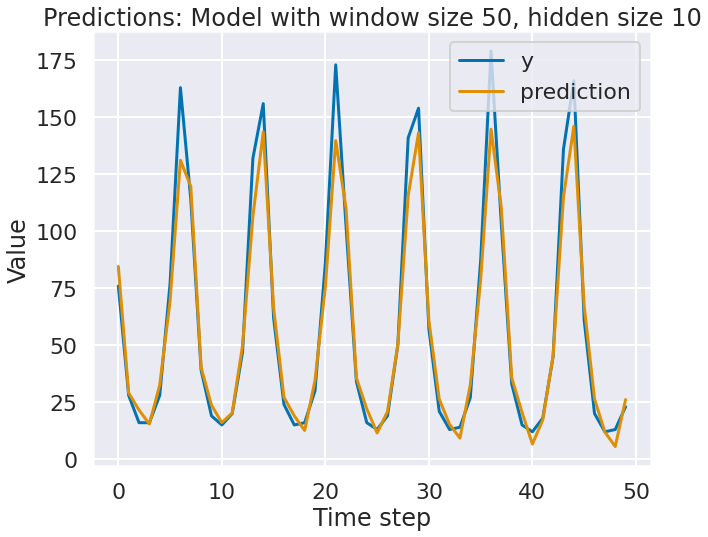

Loss (MSE): 133.34039306640625
------------------------------------------------------
Epoch 100: 0.02309473231434822
Epoch 200: 0.016733497381210327
Epoch 300: 0.012529612518846989
Epoch 400: 0.011622540652751923
Epoch 500: 0.008985328488051891
Epoch 600: 0.008347361348569393
Epoch 700: 0.007432800251990557
Epoch 800: 0.007197798229753971
Epoch 900: 0.006352242082357407
Epoch 1000: 0.006620306521654129


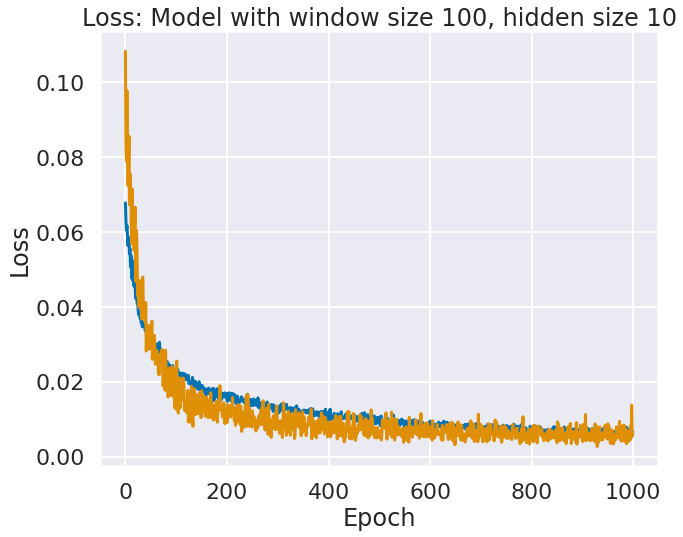

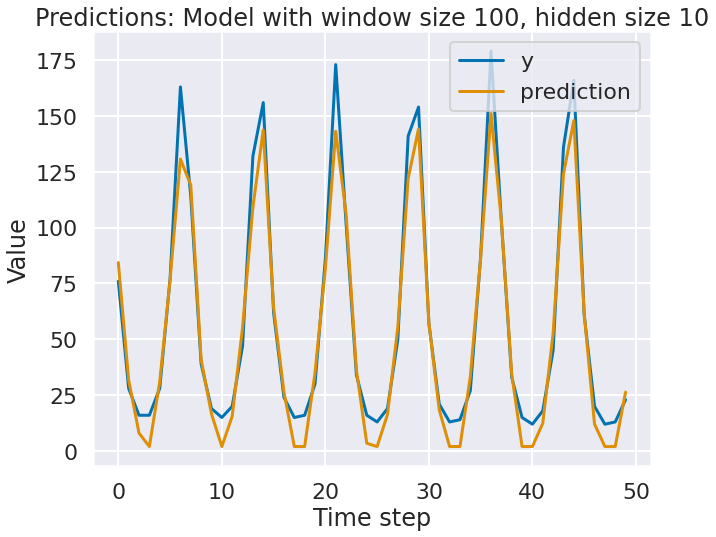

Loss (MSE): 133.61961364746094
------------------------------------------------------


In [ ]:
window_size = [10, 20, 50, 100]
hidden_size = 10
output_size =1
epochs = 1000
val_size = 50

for i in window_size:
    lstm = LSTMModel(i, hidden_size, output_size).to(device)
    min_value, max_value, normalized_data = scale_the_data(mat)
    X_train, Y_train, X_val, Y_val = make_dataset(normalized_data, i, val_size, shuffle=True)
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(lstm.parameters())
    losses, val_losses=train(X_train, Y_train, X_val, Y_val, lstm, optimizer, criterion, epochs)
    loss, y, y_pred= test(X_val, Y_val, lstm, criterion, min_value, max_value)
    plot_loss(f"Loss: Model with window size {i}, hidden size {hidden_size}", losses, val_losses)
    plot_predictions(f"Predictions: Model with window size {i}, hidden size {hidden_size}", y, y_pred)
    save(lstm, f"/content/window_size{i}_hidden_size{hidden_size}_epochs{epochs}_lstm.pt")
    print("Loss (MSE):", loss)
    print("------------------------------------------------------") 
    del lstm

Epoch 100: 0.02979147434234619
Epoch 200: 0.02485516108572483
Epoch 300: 0.019807251170277596
Epoch 400: 0.015862150117754936
Epoch 500: 0.012756126001477242
Epoch 600: 0.010641003958880901
Epoch 700: 0.009266857989132404
Epoch 800: 0.0076255034655332565
Epoch 900: 0.006298326421529055
Epoch 1000: 0.004992125555872917


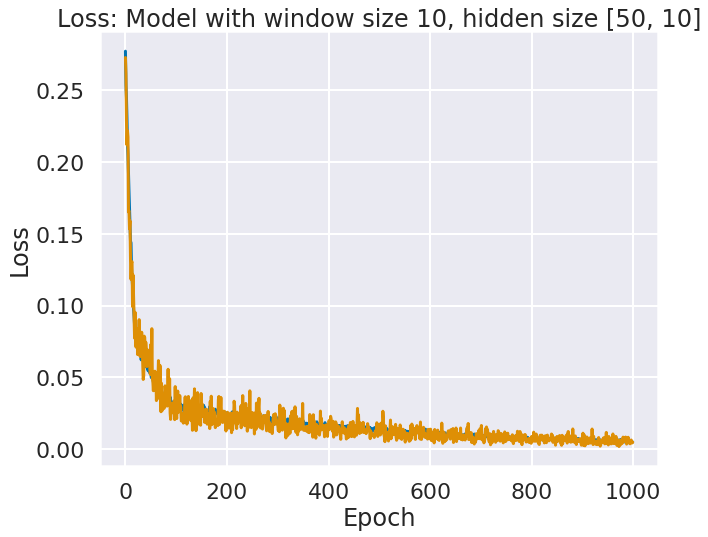

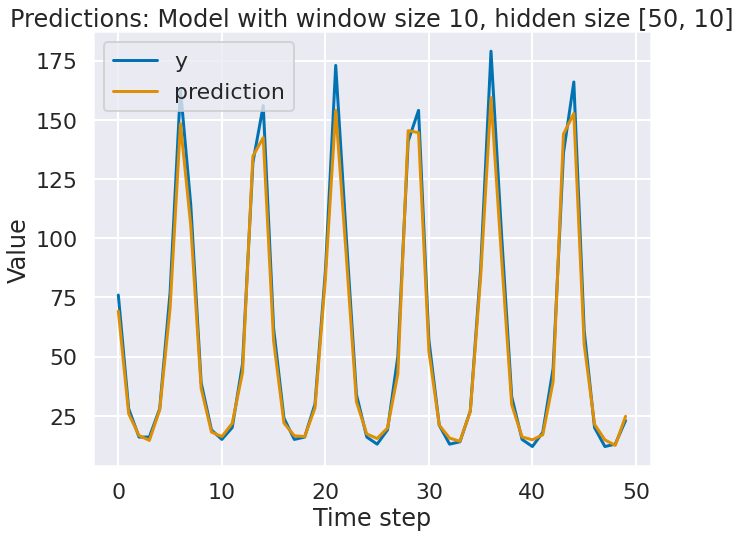

Loss (MSE): 42.52817153930664
------------------------------------------------------
Epoch 100: 0.030877867713570595
Epoch 200: 0.01944734901189804
Epoch 300: 0.014328856021165848
Epoch 400: 0.01214777585119009
Epoch 500: 0.009418321773409843
Epoch 600: 0.007514606229960918
Epoch 700: 0.005697069689631462
Epoch 800: 0.0050763655453920364
Epoch 900: 0.0042047686874866486
Epoch 1000: 0.00425855303183198


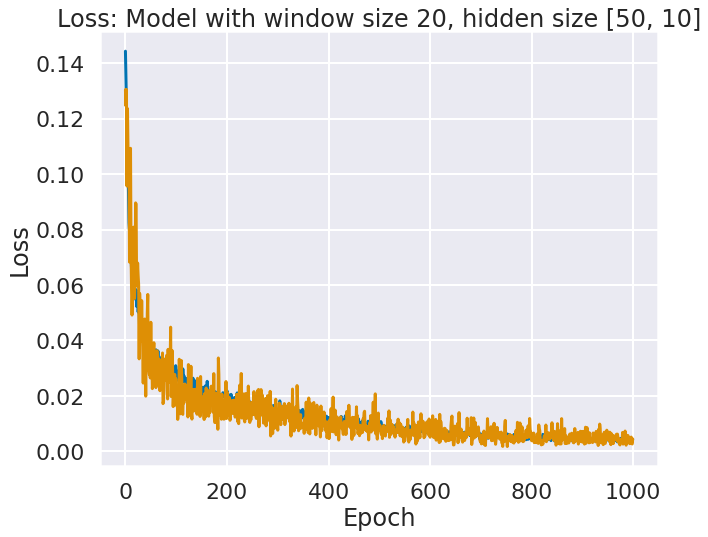

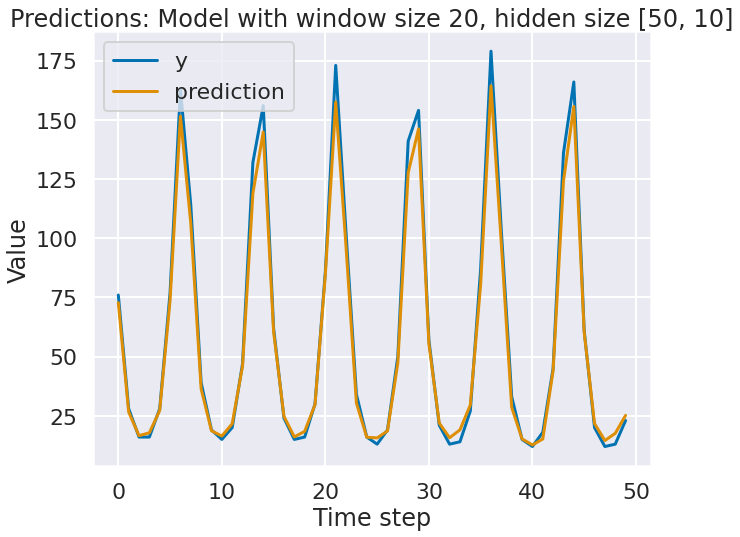

Loss (MSE): 34.37653732299805
------------------------------------------------------
Epoch 100: 0.01452902052551508
Epoch 200: 0.011244161054491997
Epoch 300: 0.008601909503340721
Epoch 400: 0.006901230197399855
Epoch 500: 0.005971279926598072
Epoch 600: 0.005096348002552986
Epoch 700: 0.004671317525207996
Epoch 800: 0.004214367363601923
Epoch 900: 0.00417106319218874
Epoch 1000: 0.004167437087744474


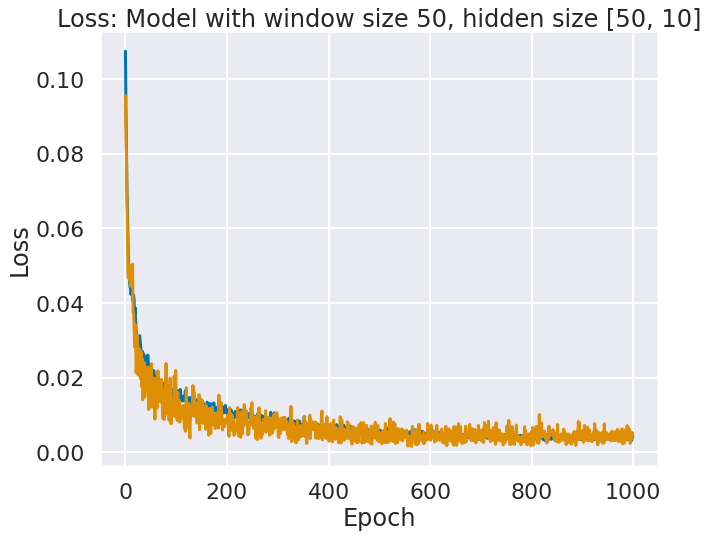

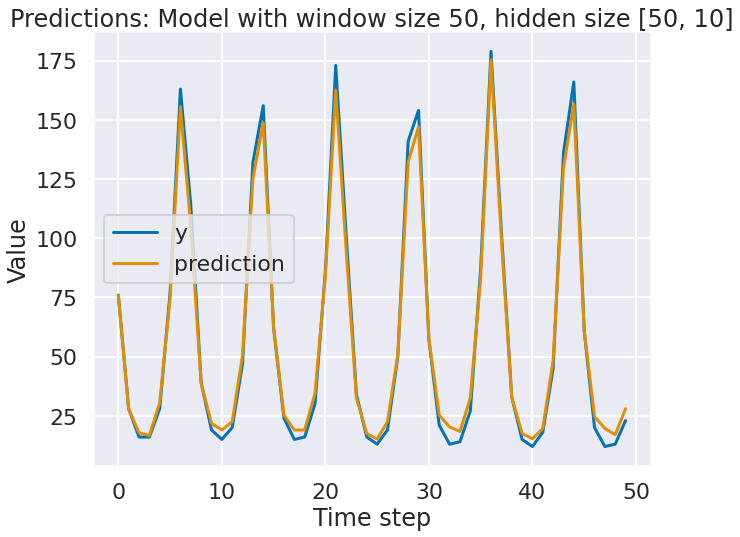

Loss (MSE): 21.622814178466797
------------------------------------------------------
Epoch 100: 0.009534185752272606
Epoch 200: 0.005860273260623217
Epoch 300: 0.0043842848390340805
Epoch 400: 0.0047113909386098385
Epoch 500: 0.003971582278609276
Epoch 600: 0.003855721093714237
Epoch 700: 0.00384730682708323
Epoch 800: 0.003325384808704257
Epoch 900: 0.00379760330542922
Epoch 1000: 0.0034595909528434277


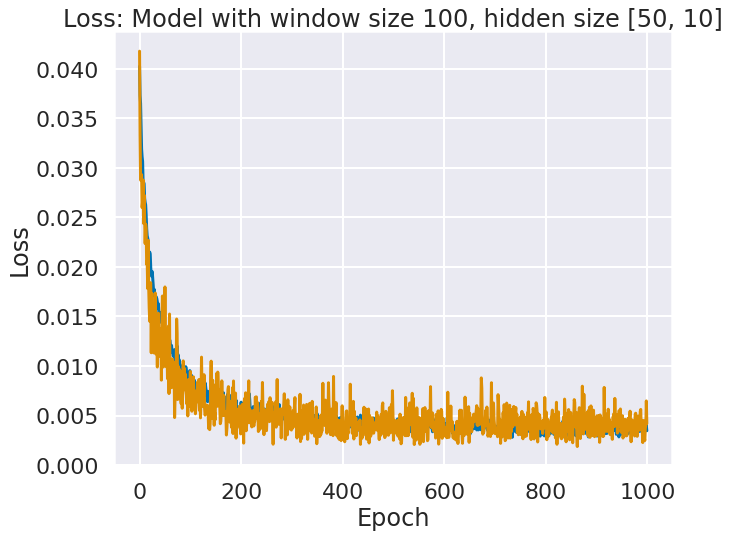

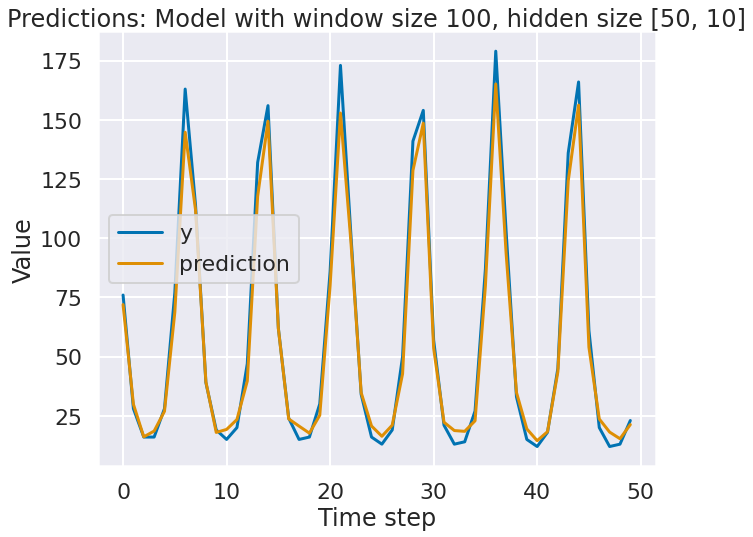

Loss (MSE): 46.641448974609375
------------------------------------------------------


In [ ]:
window_size = [10, 20, 50, 100]
hidden_size = [50, 10]
output_size =1
epochs = 1000
val_size = 50

for i in window_size:
    relu = ReLUModel(i, hidden_size, output_size).to(device)
    min_value, max_value, normalized_data = scale_the_data(mat)
    X_train, Y_train, X_val, Y_val = make_dataset(normalized_data, i, val_size, shuffle=True)
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(relu.parameters())
    losses, val_losses =train(X_train, Y_train, X_val, Y_val, relu, optimizer, criterion, epochs)
    loss, y, y_pred= test(X_val, Y_val, relu, criterion, min_value, max_value)
    plot_loss(f"Loss: Model with window size {i}, hidden size {hidden_size}", losses, val_losses)
    plot_predictions(f"Predictions: Model with window size {i}, hidden size {hidden_size}", y, y_pred)
    save(relu, f"/content/window_size{i}_hidden_size{hidden_size}_epochs{epochs}_relu.pt")
    print("Loss (MSE):", loss)
    print("------------------------------------------------------")

In [ ]:
window_size = 20
epochs = 380
hidden_size = [50, 10]
best1 = ReLUModel(window_size, hidden_size, output_size).to(device) # Decide LSTM/ReLU
min_value, max_value, normalized_data = scale_the_data(mat)
X_train, Y_train, X_val, Y_val = make_dataset(normalized_data, window_size, 0, shuffle=True)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

criterions = [
    nn.L1Loss(),
    nn.MSELoss(),
    make_RMSE()
]
optimizer = torch.optim.Adam(best1.parameters())
losses, val_losses =train(X_train, Y_train, X_val, Y_val, best1, optimizer, nn.MSELoss(), epochs)
loss, y, y_pred= test(X_train, Y_train, best1, criterions, min_value, max_value)
save(best1, "/content/best1.pt")
print("Loss (MSE) on train set:", loss)
for l, n in zip(loss, ["MAE", "MSE", "RMSE"]):
    print(n, l)

Epoch 100: 0.01640651747584343
Epoch 200: 0.011502057313919067
Epoch 300: 0.009984997101128101
Loss (MSE) on train set: [6.205383777618408, 142.56686401367188, 11.940136909484863]
MAE 6.205383777618408
MSE 142.56686401367188
RMSE 11.940136909484863


# Predict the next 200 points

In [ ]:
model = load("/content/best1.pt").to(device)

In [ ]:
window_size = 20 # needed?
min_value, max_value, normalized_data = scale_the_data(mat)
X = normalized_data[-window_size:]
X = torch.tensor(X, dtype=torch.float32).reshape(-1).to(device)

pred = model.predict(X, 200)
pred = scale_back(pred, min_value, max_value)
X = scale_back(X, min_value, max_value)

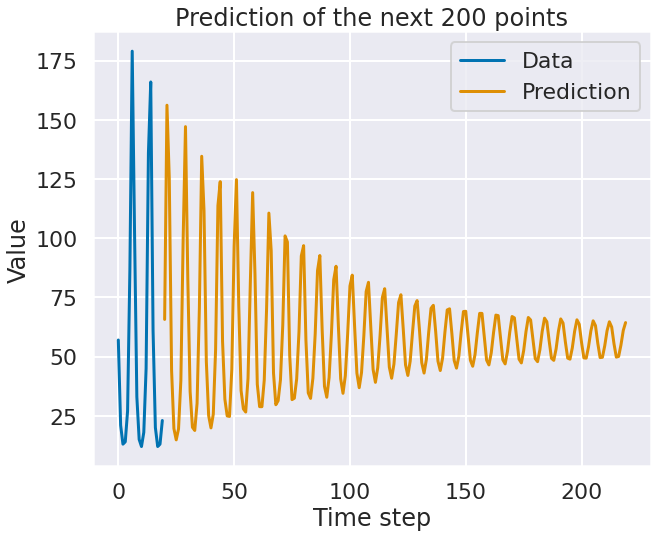

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Prediction of the next 200 points")
plt.plot(X.to("cpu"), label="Data")
plt.plot([i+len(X) for i in range(len(pred.to("cpu")))], pred.to("cpu").detach(), label="Prediction")
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Value")
plt.show()

# Test the models

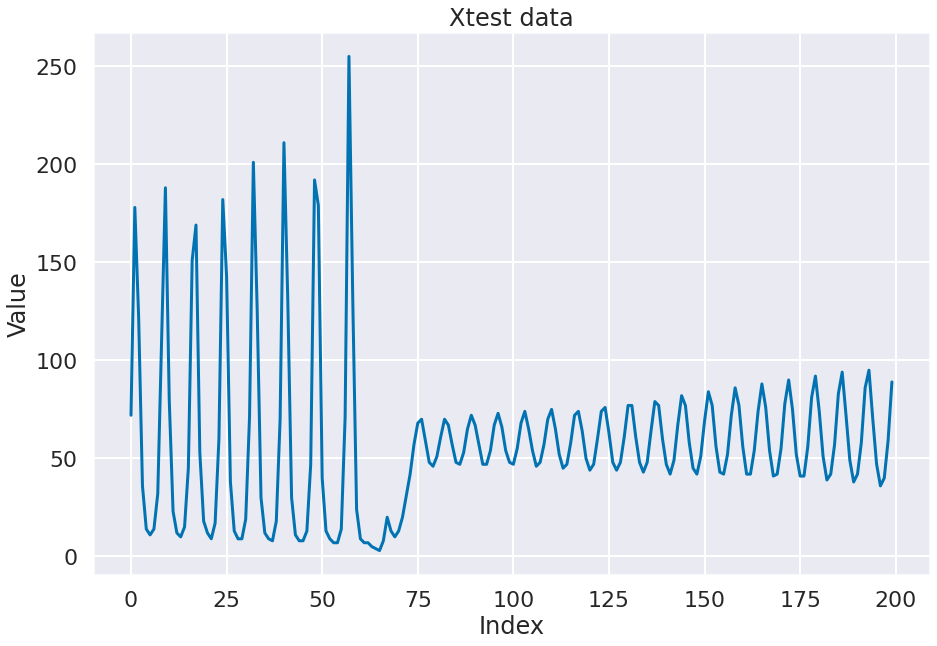

In [ ]:
mat = scipy.io.loadmat("Xtest.mat")["Xtest"]
plt.figure(figsize=(15, 10))
plt.plot(mat)
plt.title("Xtest data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [ ]:
model = load("/content/best1.pt").to(device)
window_size = 20

min_value, max_value, normalized_data = scale_the_data(mat)
X_test, Y_test, _, _ = make_dataset(normalized_data, window_size, shuffle= False)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).reshape(-1).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([180])) that is different to the input size (torch.Size([180, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([180])) that is different to the input size (torch.Size([180, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MAE 33.8636589050293
MSE 2330.8369140625
RMSE 48.278743743896484


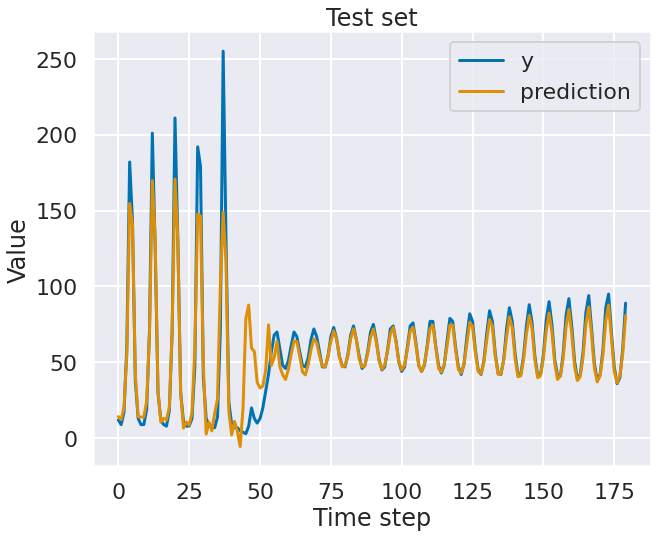

In [ ]:
criterions = [
    nn.L1Loss(),
    nn.MSELoss(),
    make_RMSE()
]
test_losses, y, y_pred =  test(X_test, Y_test, model, criterions, min_value, max_value)
for l, n in zip(test_losses, ["MAE", "MSE", "RMSE"]):
    print(n, l)
plot_predictions("Test set", y, y_pred)

In [ ]:
X_train.shape

torch.Size([750, 1, 100])